In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import joblib
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    confusion_matrix, RocCurveDisplay
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder,StandardScaler

In [79]:
df = sns.load_dataset("titanic")
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [80]:
df.isnull().sum()

,0
survived,0
pclass,0
sex,0
age,177
sibsp,0
parch,0
fare,0
embarked,2
class,0
who,0


In [81]:
df.drop("deck",axis=1,inplace=True)

In [82]:
df['age'] = df['age'].fillna(df["age"].mean())

In [83]:
df.dropna(inplace=True)

In [84]:
df.isnull().sum()

,0
survived,0
pclass,0
sex,0
age,0
sibsp,0
parch,0
fare,0
embarked,0
class,0
who,0


In [85]:
categorical = df.select_dtypes(include=["object","category"]).columns
numerical = df.select_dtypes(include=["int64","float64"]).columns
print(f"Categorical: {categorical}")
print(f"Numerical: {numerical}")

Categorical: Index(['sex', 'embarked', 'class', 'who', 'embark_town', 'alive'], dtype='object')
Numerical: Index(['survived', 'pclass', 'age', 'sibsp', 'parch', 'fare'], dtype='object')


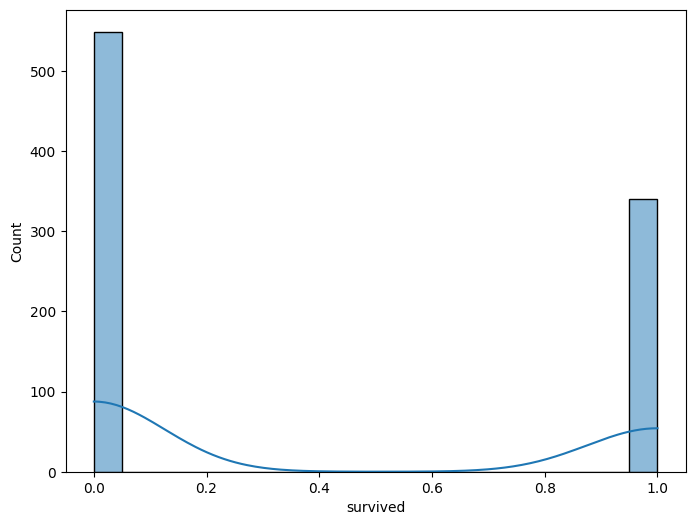

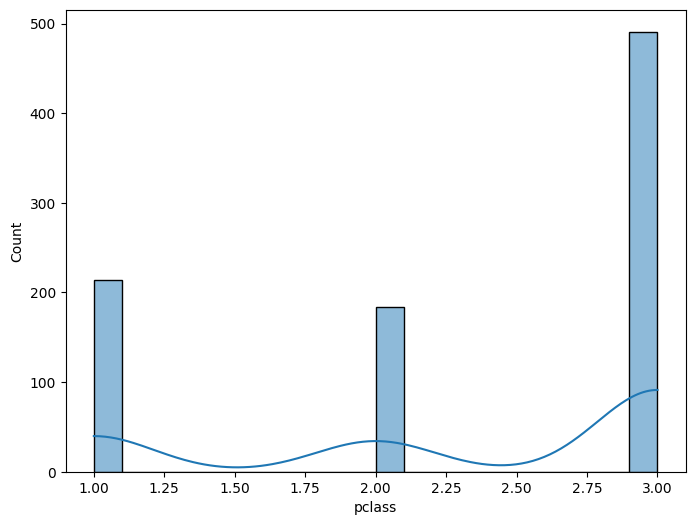

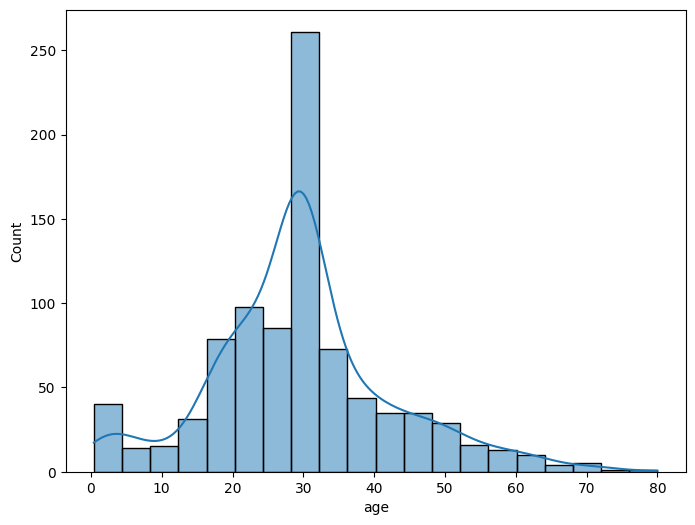

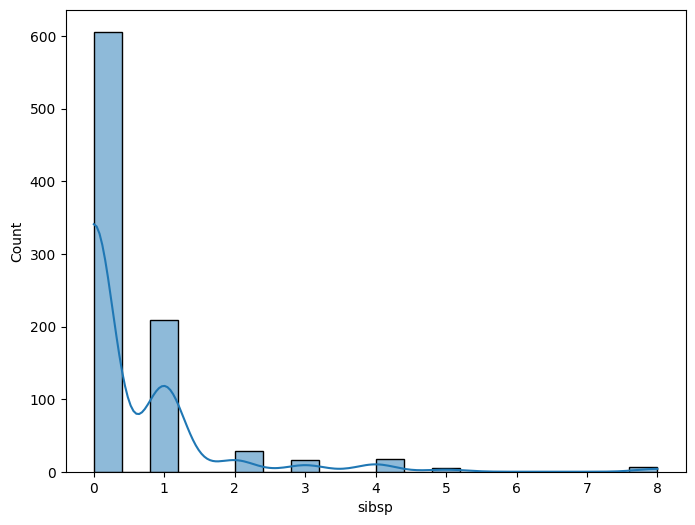

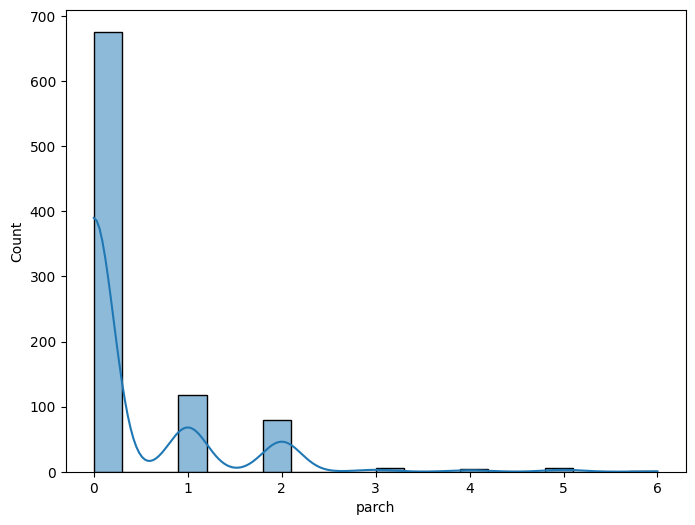

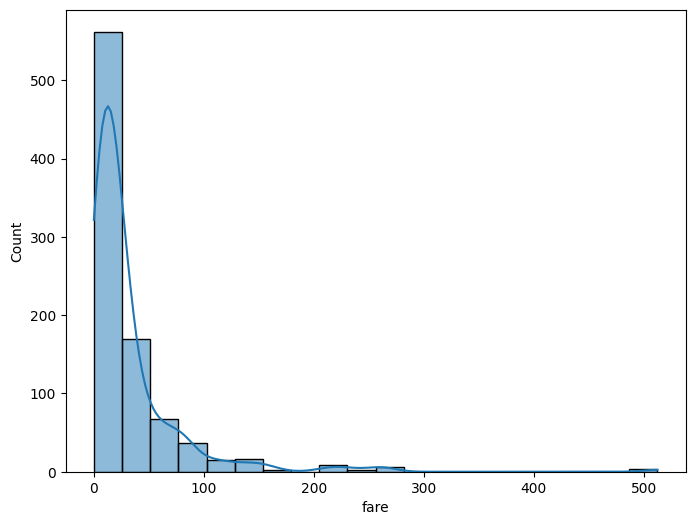

In [86]:
for col in numerical:
  plt.figure(figsize=(8,6))
  sns.histplot(df[col],bins=20,kde=True)

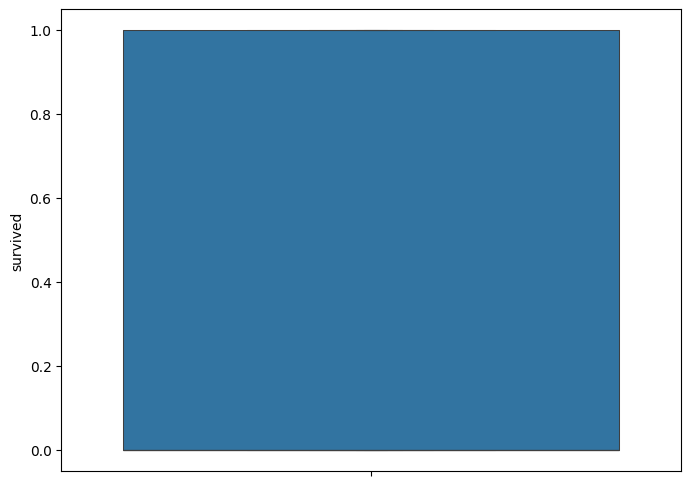

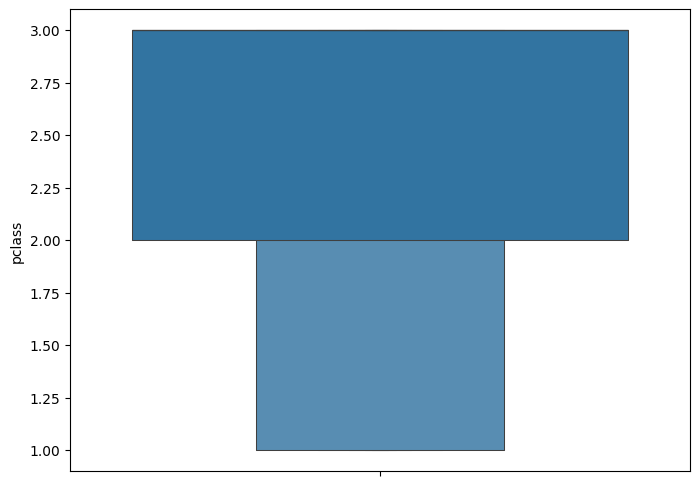

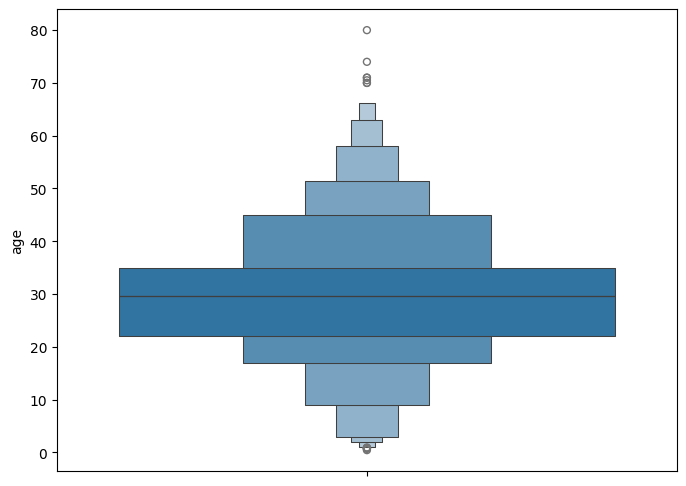

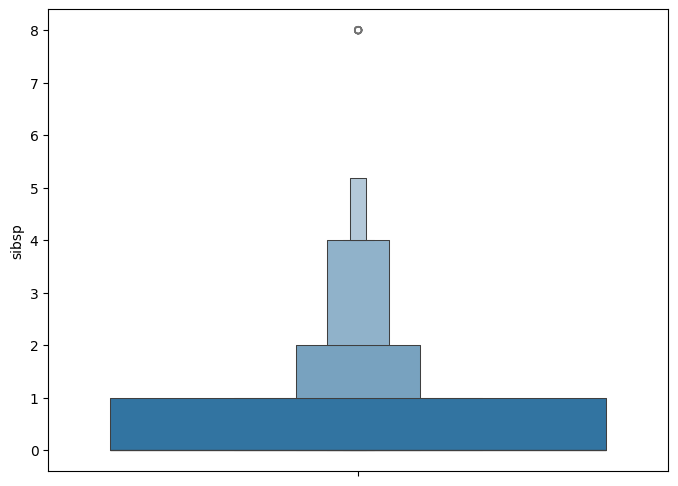

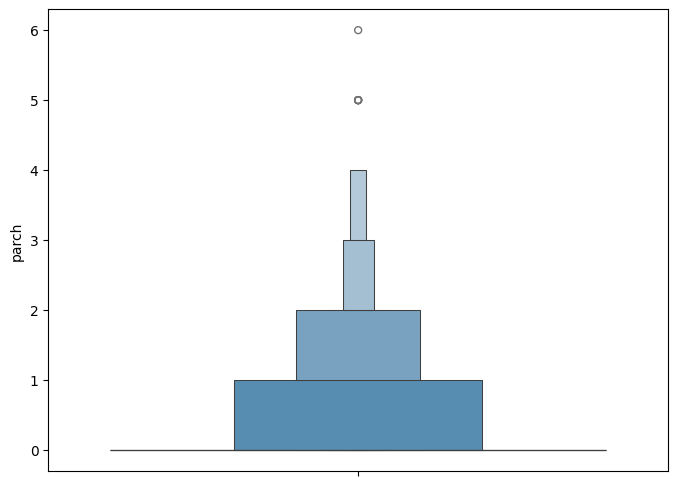

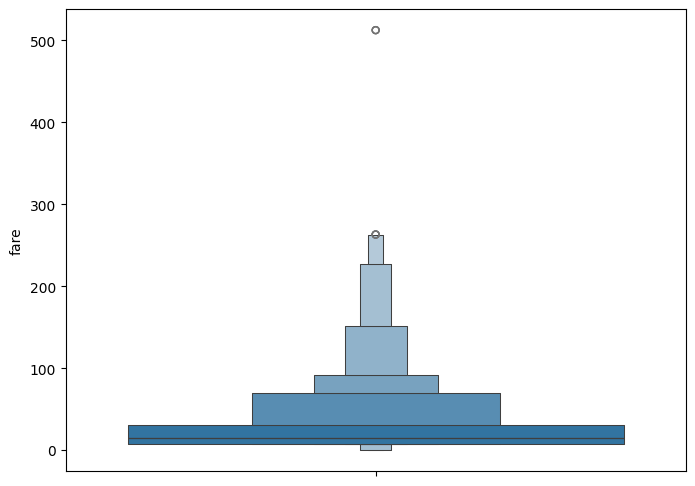

In [87]:
for col in numerical:
  plt.figure(figsize=(8,6))
  sns.boxenplot(df[col])

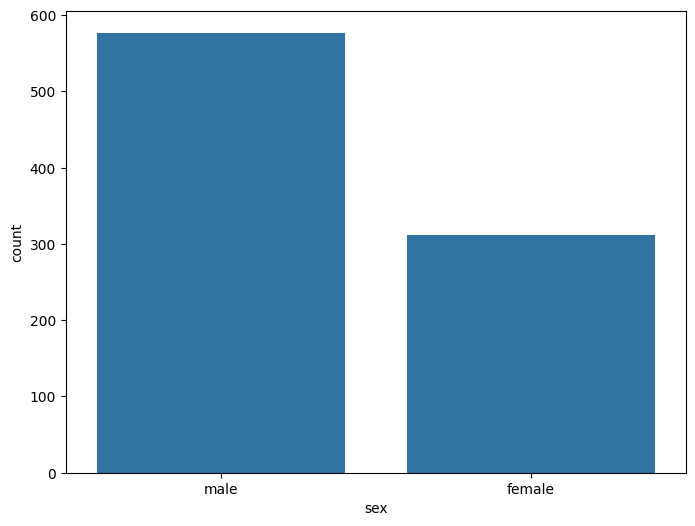

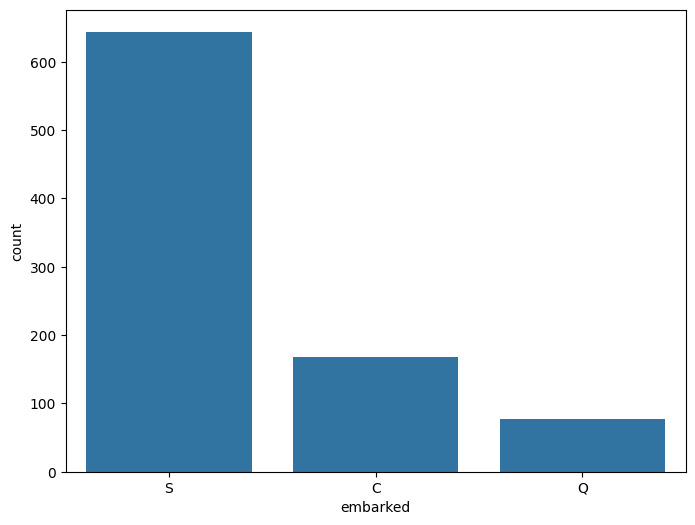

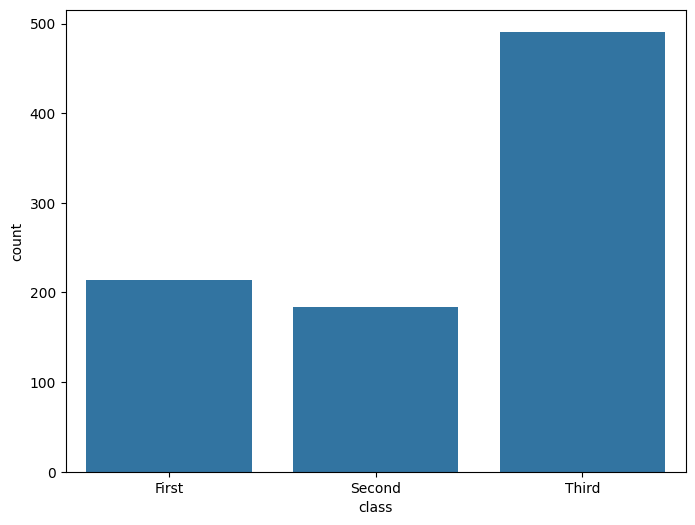

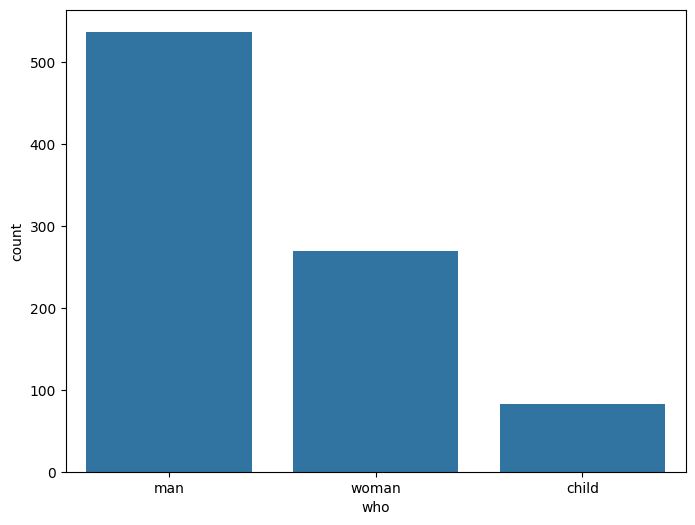

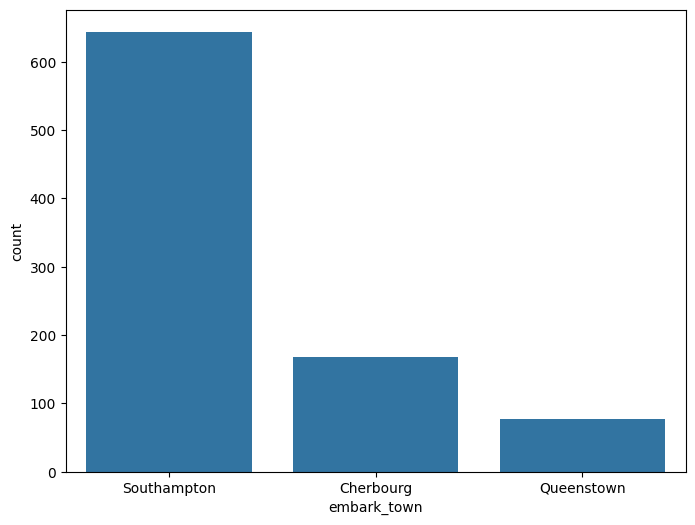

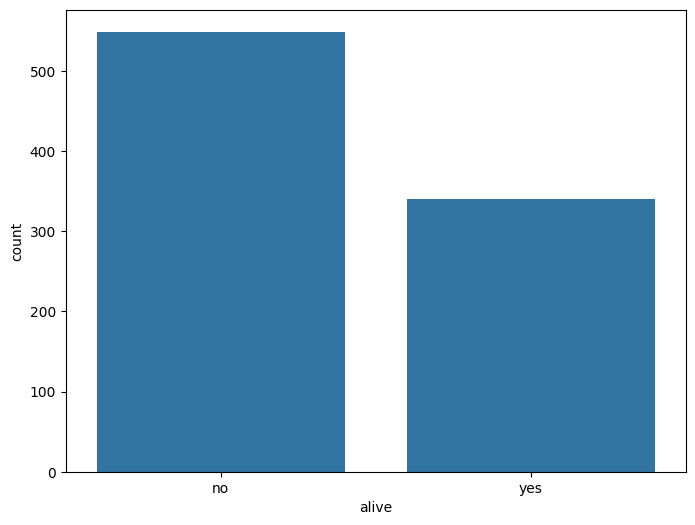

In [88]:
for col in categorical:
  plt.figure(figsize=(8,6))
  sns.countplot(x=df[col])

<Axes: >

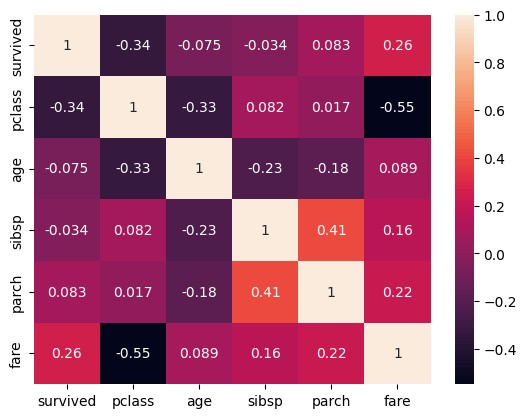

In [89]:
sns.heatmap(data=df[numerical].corr(),annot=True)

In [90]:
le = LabelEncoder()

In [91]:
label_en = [col for col in categorical if df[col].nunique()==2]
hot_en = [col for col in categorical if df[col].nunique()>2]
print(f"Label: {label_en}")
print(f"Hot: {hot_en}")

Label: ['sex', 'alive']
Hot: ['embarked', 'class', 'who', 'embark_town']


In [92]:
for col in label_en:
  df[col] = le.fit_transform(df[col])

In [93]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,embark_town,alive,alone
0,0,3,1,22.0,1,0,7.2500,S,Third,man,True,Southampton,0,False
1,1,1,0,38.0,1,0,71.2833,C,First,woman,False,Cherbourg,1,False
2,1,3,0,26.0,0,0,7.9250,S,Third,woman,False,Southampton,1,True
3,1,1,0,35.0,1,0,53.1000,S,First,woman,False,Southampton,1,False
4,0,3,1,35.0,0,0,8.0500,S,Third,man,True,Southampton,0,True


In [94]:
df= pd.get_dummies(df,columns=hot_en)

In [95]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,adult_male,alive,alone,embarked_C,embarked_Q,embarked_S,class_First,class_Second,class_Third,who_child,who_man,who_woman,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton
0,0,3,1,22.0,1,0,7.2500,True,0,False,False,False,True,False,False,True,False,True,False,False,False,True
1,1,1,0,38.0,1,0,71.2833,False,1,False,True,False,False,True,False,False,False,False,True,True,False,False
2,1,3,0,26.0,0,0,7.9250,False,1,True,False,False,True,False,False,True,False,False,True,False,False,True
3,1,1,0,35.0,1,0,53.1000,False,1,False,False,False,True,True,False,False,False,False,True,False,False,True
4,0,3,1,35.0,0,0,8.0500,True,0,True,False,False,True,False,False,True,False,True,False,False,False,True


In [96]:
X = df.drop("survived",axis=1)
y = df["survived"]

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,stratify=y)

In [98]:
pipelines = {
        'decision_tree': Pipeline([('clf', DecisionTreeClassifier(random_state=42))]),
        'random_forest': Pipeline([('clf', RandomForestClassifier(random_state=42))]),
        'logistic': Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(solver='liblinear', random_state=42))]),
        'naive_bayes': Pipeline([('scaler', StandardScaler()), ('clf', GaussianNB())]),
        'svc': Pipeline([('scaler', StandardScaler()), ('clf', SVC(probability=True, random_state=42))]),
        'knn': Pipeline([('scaler', StandardScaler()), ('clf', KNeighborsClassifier())]),
    }

In [99]:
param_grids = {
        'decision_tree': {
            'clf__max_depth': [None, 3, 5, 8],
            'clf__min_samples_split': [2, 5, 10]
        },
        'random_forest': {
            'clf__n_estimators': [50, 100],
            'clf__max_depth': [None, 5, 10],
            'clf__min_samples_split': [2, 5]
        },
        'logistic': {
            'clf__C': [0.01, 0.1, 1, 10],
            'clf__penalty': ['l1', 'l2']
        },
        'naive_bayes': {
            # GaussianNB has fewer hyperparams; include a small var smoothing sweep
            'clf__var_smoothing': [1e-9, 1e-8, 1e-7]
        },
        'svc': {
            'clf__C': [0.1, 1, 10],
            'clf__kernel': ['rbf', 'linear'],
            'clf__gamma': ['scale', 'auto']
        },
        'knn': {
            'clf__n_neighbors': [3, 5, 7],
            'clf__weights': ['uniform', 'distance'],
            'clf__p': [1, 2]  # Manhattan (1) and Euclidean (2)
        }
    }

In [100]:
results = []

In [101]:
for name, pipe in pipelines.items():
        print(f"\n=== {name.upper()} ===")
        grid = GridSearchCV(
            estimator=pipe,
            param_grid=param_grids[name],
            scoring='accuracy',    # primary metric for search
            cv=5,
            n_jobs=-1,
            verbose=0
        )
        t0 = time()
        grid.fit(X_train, y_train)
        t1 = time()

        best_est = grid.best_estimator_
        best_params = grid.best_params_
        best_score = grid.best_score_

        # Evaluate on test set
        y_pred = best_est.predict(X_test)
        y_proba = None
        try:
            y_proba = best_est.predict_proba(X_test)[:, 1]
        except Exception:
            # some classifiers may not have predict_proba (should have since we set probability True for SVC)
            y_proba = best_est.decision_function(X_test)
            # if decision_function returns shape (n_samples,), we need to convert later for ROC

        acc = accuracy_score(y_test, y_pred)
        # roc_auc_score needs probabilities / scores and binary labels
        try:
            roc = roc_auc_score(y_test, y_proba)
        except Exception:
            roc = np.nan

        print(f"Time for grid search + fit: {t1 - t0:.2f}s")
        print(f"Best CV accuracy: {best_score:.4f}")
        print(f"Test set accuracy: {acc:.4f}")
        print(f"Test ROC AUC: {roc:.4f}")
        print("Best params:", best_params)
        print("\nClassification report (test set):")
        print(classification_report(y_test, y_pred, digits=4))
        print("Confusion matrix (rows = true, cols = pred):")
        print(confusion_matrix(y_test, y_pred))

        results.append({
            'model': name,
            'best_cv_accuracy': best_score,
            'test_accuracy': acc,
            'test_roc_auc': roc,
            'best_params': best_params,
            'fit_time_s': t1 - t0
        })


=== DECISION_TREE ===
Time for grid search + fit: 0.39s
Best CV accuracy: 1.0000
Test set accuracy: 1.0000
Test ROC AUC: 1.0000
Best params: {'clf__max_depth': None, 'clf__min_samples_split': 2}

Classification report (test set):
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       182
           1     1.0000    1.0000    1.0000       112

    accuracy                         1.0000       294
   macro avg     1.0000    1.0000    1.0000       294
weighted avg     1.0000    1.0000    1.0000       294

Confusion matrix (rows = true, cols = pred):
[[182   0]
 [  0 112]]

=== RANDOM_FOREST ===
Time for grid search + fit: 7.88s
Best CV accuracy: 1.0000
Test set accuracy: 1.0000
Test ROC AUC: 1.0000
Best params: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 50}

Classification report (test set):
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       182
         

In [102]:
df_results = pd.DataFrame(results).sort_values('test_accuracy', ascending=False).reset_index(drop=True)
print("\n\n=== SUMMARY RANKED BY TEST ACCURACY ===")
print(df_results[['model', 'best_cv_accuracy', 'test_accuracy', 'test_roc_auc', 'fit_time_s']])



=== SUMMARY RANKED BY TEST ACCURACY ===
           model  best_cv_accuracy  test_accuracy  test_roc_auc  fit_time_s
0  decision_tree          1.000000       1.000000      1.000000    0.388298
1  random_forest          1.000000       1.000000      1.000000    7.879776
2       logistic          1.000000       1.000000      1.000000    0.417747
3    naive_bayes          1.000000       1.000000      1.000000    0.144903
4            svc          1.000000       1.000000      1.000000    1.317014
5            knn          0.976471       0.972789      0.979199    0.573551


In [103]:
best_model_name = df_results.iloc[0]['model']
print(f"\nBest model overall: {best_model_name}")


Best model overall: decision_tree


In [104]:
best_pipe = pipelines[best_model_name]
best_pipe.set_params(**df_results.iloc[0]['best_params'])
best_pipe.fit(X_train, y_train)
joblib.dump(best_pipe, "best_model.pkl")
print("✅ Saved best model as best_model.pkl")

✅ Saved best model as best_model.pkl
